(demo2022-06-27)=
# Demo Notebook 2022-06-27

Demos from the live sessions on 2022-06-27.


## Setup

Ye olde setup chunk below.


In [1]:
import grama as gr
import pandas as pd
DF = gr.Intention()
%matplotlib inline

# For downloading data
import os
import requests

Download the michelson data.


In [2]:
# Filename for local data
filename_data = "../challenges_assignment/data/michelson.csv"

# The following code downloads the data, or (after downloaded)
# loads the data from a cached CSV on your machine
if not os.path.exists(filename_data):
    # Make request for data
    url_data = "https://docs.google.com/spreadsheets/d/1av_SXn4j0-4Rk0mQFik3LLr-uf0YdA06i3ugE6n-Zdo/export?format=csv"
    r = requests.get(url_data, allow_redirects=True)
    open(filename_data, 'wb').write(r.content)
    print("   Data downloaded from public Google sheet")
else:
    # Note data already exists
    print("   Data loaded locally")
    
# Read the data into memory
df_michelson = (
    pd.read_csv(filename_data)
    >> gr.tf_select("Date", "Distinctness", "Temp", "Velocity")
)

# Adjust values
df_q2 = (
    df_michelson
    >> gr.tf_mutate(VelocityVacuum=DF.Velocity + 92)
)

   Data loaded locally


In [3]:
## NOTE: Don't edit; these are constants used in the challenge
LIGHTSPEED_VACUUM    = 299792.458 # Exact speed of light in a vacuum (km / s)
LIGHTSPEED_MICHELSON = 299944.00  # Michelson's speed estimate (km / s)
LIGHTSPEED_PM        = 51         # Michelson error estimate (km / s)


## Temperature dependence

Part of what makes analyzing the Michelson data difficult---and not fooling ourselves into seeing spurious patterns---is that the speed of light (in air) *does* have a temperature dependence. Let's compare that dependence to the observed trend in the data.

For temperature, I'm pulling an index-of-refraction calculation for [air](https://physics.stackexchange.com/questions/6872/refractive-index-of-air-in-dependence-of-temperature) to adjust the speed-of-light from vacuum to that in air.


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


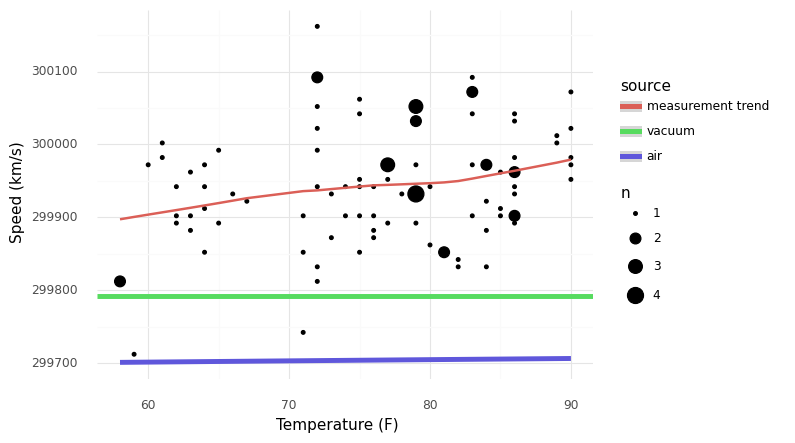

<ggplot: (8790976147962)>

In [4]:
(
    df_q2
    >> gr.ggplot(gr.aes("Temp", "VelocityVacuum"))
    + gr.geom_count()
    + gr.geom_smooth(
        data=df_q2
        >> gr.tf_mutate(source="measurement trend"),
        mapping=gr.aes(color="source"),
    )
    + gr.geom_hline(
        data=gr.df_make(c_vacuum=[LIGHTSPEED_VACUUM], source="vacuum"),
        mapping=gr.aes(yintercept="c_vacuum", color="source"),
        size=2,
    )
    + gr.geom_line(
        data=df_q2
        >> gr.tf_mutate(T_K=(DF.Temp - 32) * 5/9 + 273.15) # Convert T to kelvin
        >> gr.tf_mutate(n=1 + 0.000293 * 300 / DF.T_K)     # Compute index of refraction
        >> gr.tf_mutate(c_air=LIGHTSPEED_VACUUM / DF.n)    # Compute speed in air
        >> gr.tf_mutate(source="air"),
        mapping=gr.aes(y="c_air", color="source"),
        size=2,
    )
    + gr.theme_minimal()
    + gr.labs(
        x="Temperature (F)",
        y="Speed (km/s)",
    )
)


As we can see, the measurement trend in temperature is much steeper than the real trend in air. This suggests that much of the variation in temperature that we see is *erroneous* (not real).

One of the challenges in making this kind of determination is that what is real and what is erroneous *depends on what we are trying to study*. While temperature *does* affect the speed of light in air, it *does not* affect the speed of light in a vacuum. Let's compare a couple of physical mechanisms, and note whether they are real or error for different quantities:

| Physical mechanism | For lightspeed in air | For lightspeed in vacuum |
|--------------------|-----------------------|--------------------------|
| Miscalibrated instrument | Error | Error |
| Temperature changes index of refraction of air | Real | Error |
 